In [1]:
#Importing Libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=5
CHANNELS=3

**Importing data into tensorflow dataset object**

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 285 files belonging to 3 classes.


**Explanatory Data Analysis(EDA)**

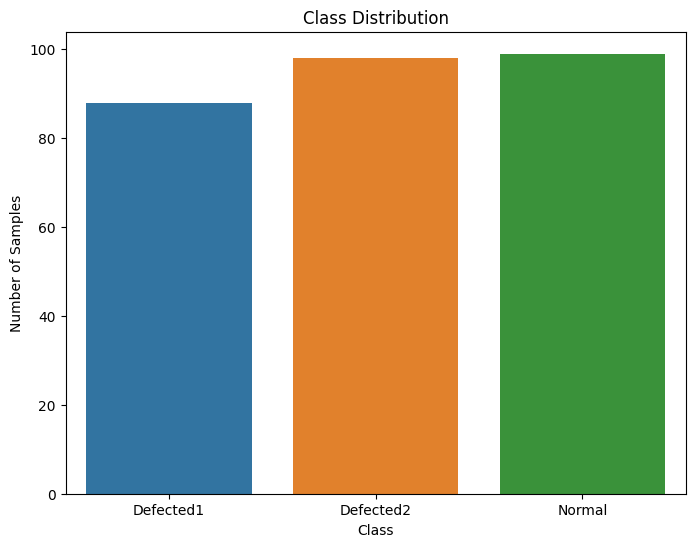

In [21]:
#Knowing About the Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
dataset_dir = "Dataset"
class_names = os.listdir(dataset_dir)
class_counts = [len(os.listdir(os.path.join(dataset_dir, cls))) for cls in class_names]
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

**Visualizing some of the images from the dataset**

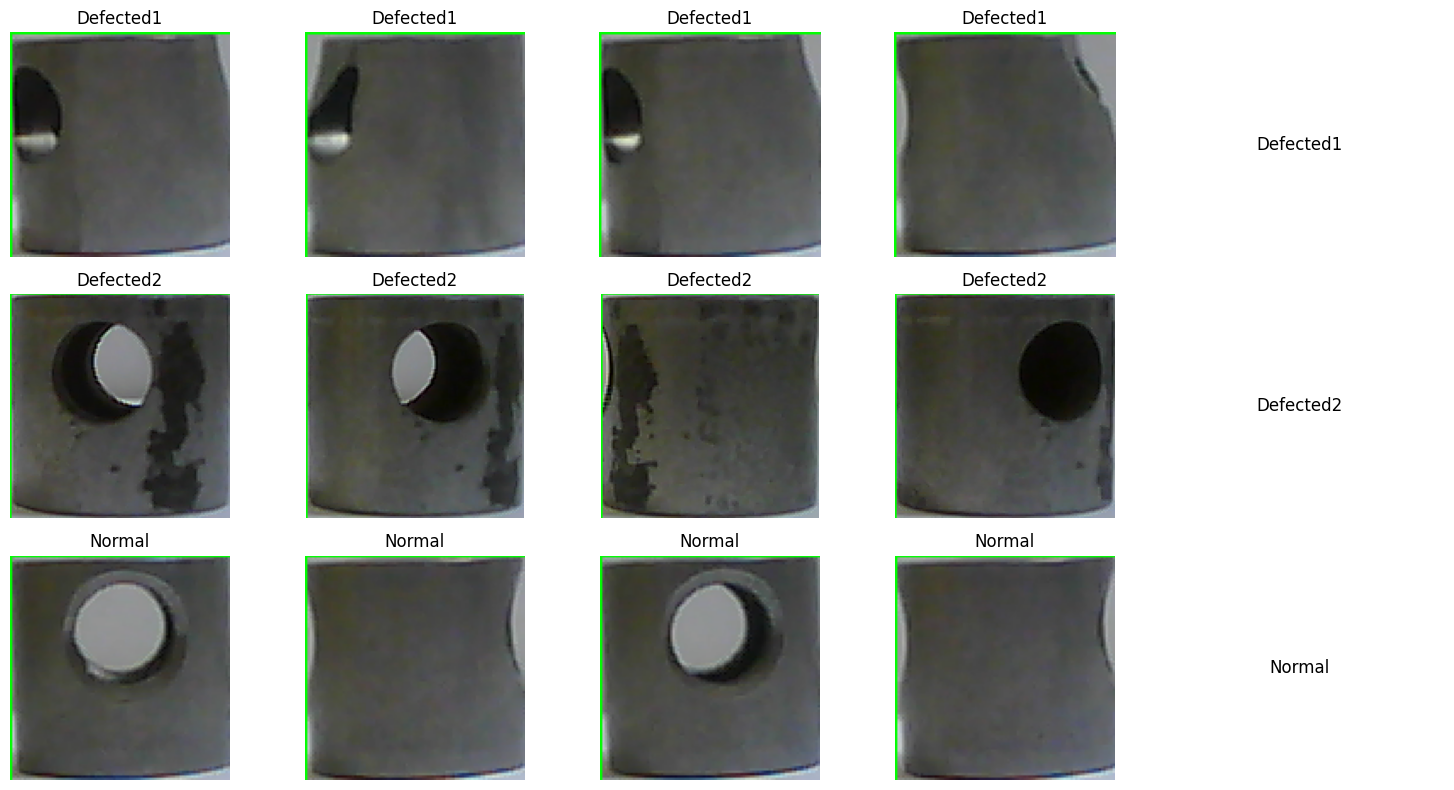

In [22]:
import random
from matplotlib.gridspec import GridSpec
def get_random_images(class_name, num_images=4):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [Image.open(os.path.join(class_dir, img)) for img in random_images]

num_images_per_class = 4

grid_rows = len(class_names)
grid_cols = num_images_per_class + 1 
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(grid_rows, grid_cols, figure=fig)

for i, cls in enumerate(class_names):
    random_images = get_random_images(cls, num_images=num_images_per_class)
    for j, image in enumerate(random_images):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(image)
        ax.set_title(cls)
        ax.axis("off")
    ax_class_name = fig.add_subplot(gs[i, num_images_per_class])
    ax_class_name.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12)
    ax_class_name.axis("off")
plt.tight_layout()
plt.show()


**Splitting Dataset**
1.Training
2.Validation
3.Test

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

45

In [24]:
len(val_ds)

5

In [25]:
len(test_ds)

7

**Cache, Shuffle, and Prefetch the Dataset**

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Creating a Layer for Resizing and Normalization**

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [9]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


**CNN Model Architecture**

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (5, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (5, 254, 254, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (5, 127, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (5, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (5, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (5, 60, 60, 64)          

**Compiling the Model**

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
45/45 [==============================] - 20s 375ms/step - loss: 1.1031 - accuracy: 0.3111 - val_loss: 1.0984 - val_accuracy: 0.2800
Epoch 2/50
45/45 [==============================] - 18s 391ms/step - loss: 1.0990 - accuracy: 0.3556 - val_loss: 1.0828 - val_accuracy: 0.4000
Epoch 3/50
45/45 [==============================] - 20s 452ms/step - loss: 0.9661 - accuracy: 0.5067 - val_loss: 0.9087 - val_accuracy: 0.7600
Epoch 4/50
45/45 [==============================] - 22s 484ms/step - loss: 0.8441 - accuracy: 0.6222 - val_loss: 0.6045 - val_accuracy: 0.8800
Epoch 5/50
45/45 [==============================] - 18s 404ms/step - loss: 0.8317 - accuracy: 0.6089 - val_loss: 0.7084 - val_accuracy: 0.8800
Epoch 6/50
45/45 [==============================] - 20s 435ms/step - loss: 0.6706 - accuracy: 0.6889 - val_loss: 0.6147 - val_accuracy: 0.8400
Epoch 7/50
45/45 [==============================] - 22s 490ms/step - loss: 0.5758 - accuracy: 0.7156 - val_loss: 0.4326 - val_accuracy: 0.8400

In [14]:
scores=model.evaluate(test_ds)


7/7 [==============================] - 10s 1s/step - loss: 0.0038 - accuracy: 1.0000


In [15]:
scores

[0.0037509326357394457, 1.0]

In [16]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 45}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plotting the Accuracy and Loss Curves

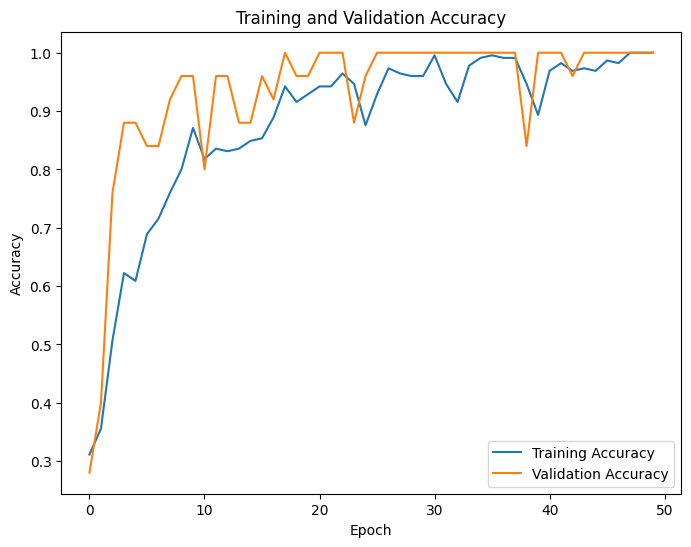

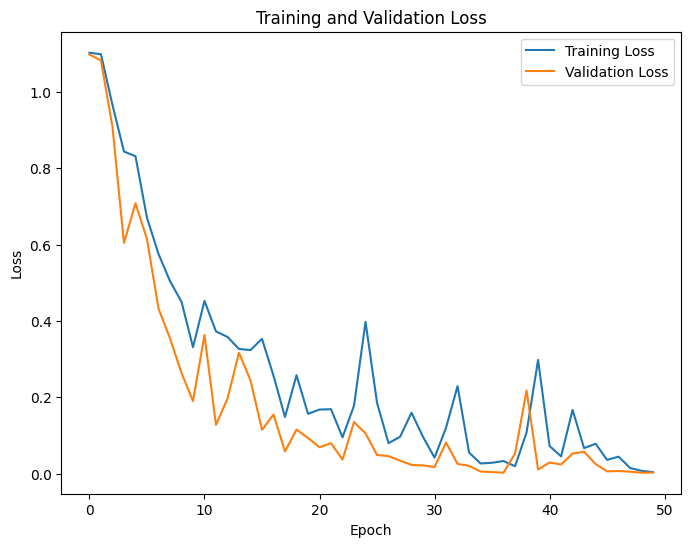

In [33]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Running prediction on a sample image

first image to predict
actual label: Defected1
1/1 [==============================] - 0s 200ms/step
predicted label: Defected1


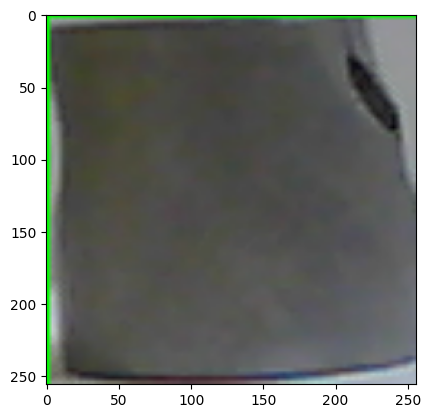

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Visualizing the prediction**

1/7 [===>..........................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

7/7 [==============================] - 1s 103ms/step - loss: 0.0038 - accuracy: 1.0000
Test Loss: 0.0037509321700781584, Test Accuracy: 1.0
1/1 [==============================] - 0s 122ms/step


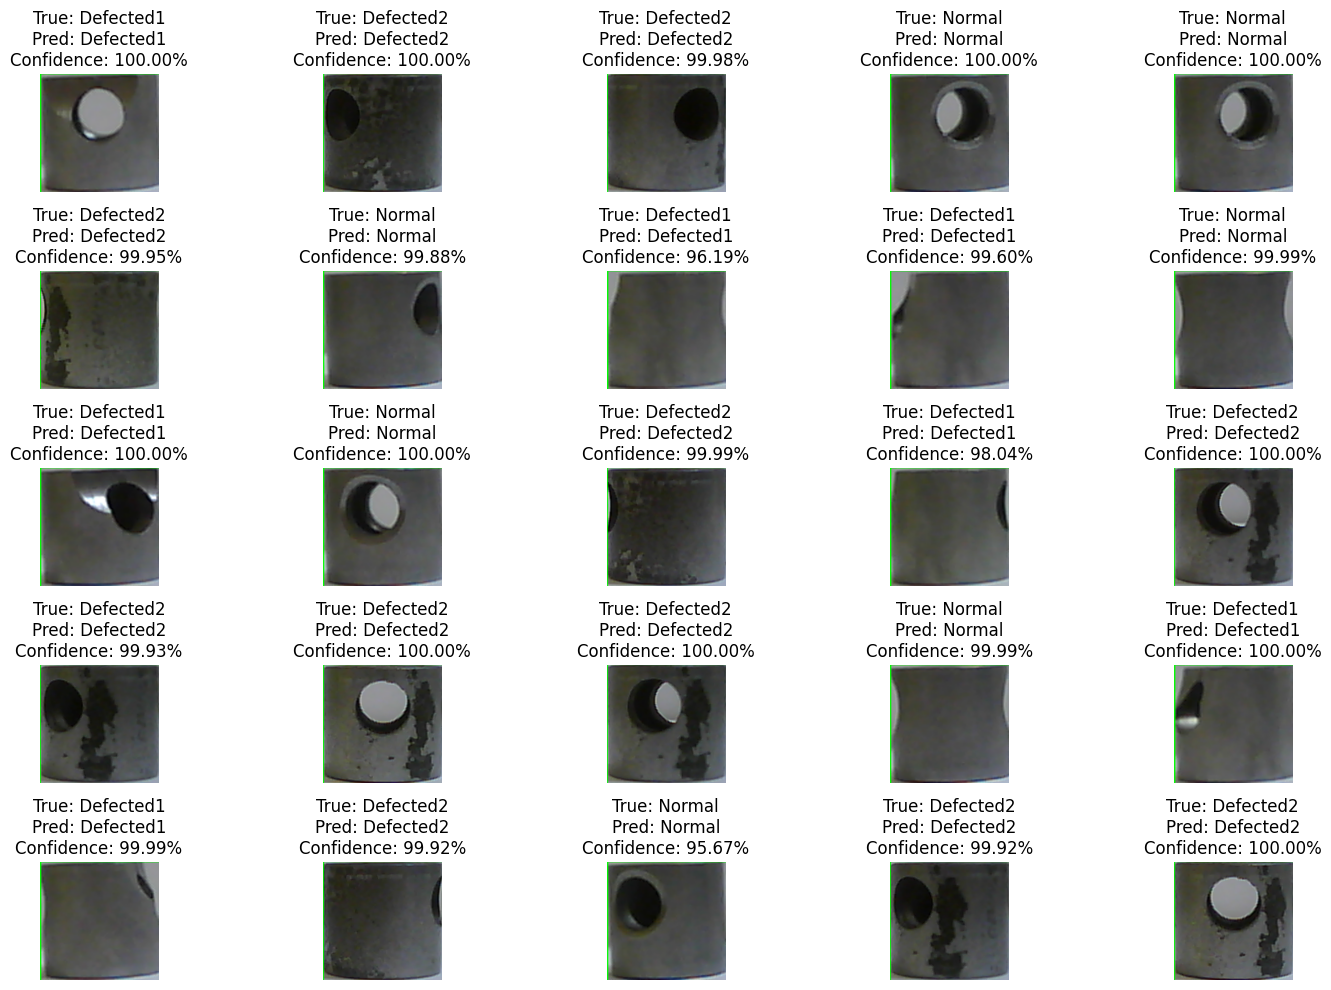

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_predictions(model, test_ds, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(test_ds.take(num_samples)):
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=-1)
        confidence_scores = np.max(predictions, axis=-1) * 100  # Convert to percentage

        for j in range(images.shape[0]):
            plt.subplot(num_samples, 5, i * 5 + j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[j]]}\nPred: {class_names[pred_labels[j]]}\nConfidence: {confidence_scores[j]:.2f}%")
            plt.axis("off")

    plt.tight_layout()
    plt.show()
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

visualize_predictions(model, test_ds, class_names)

1/1 [==============================] - 0s 50ms/step


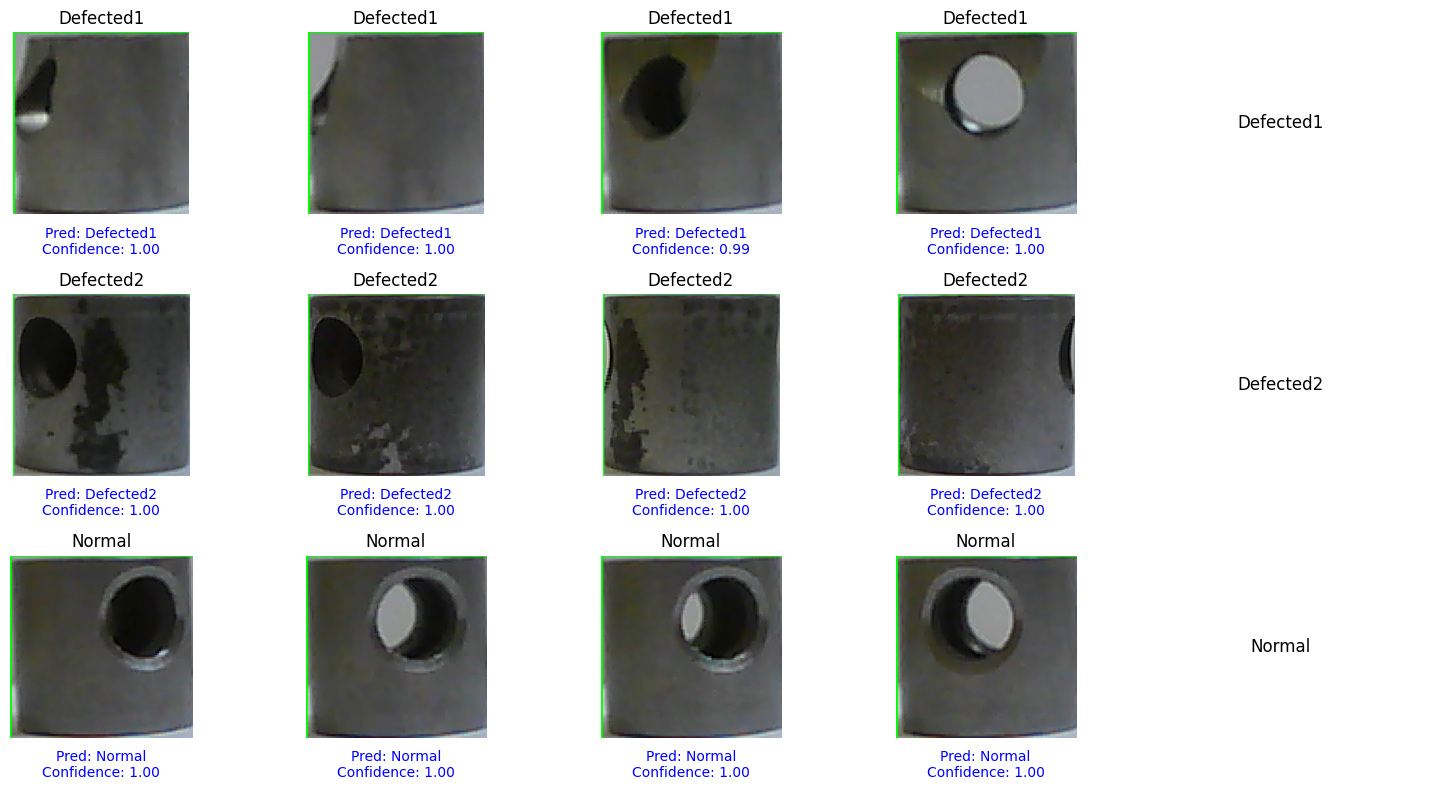

In [28]:
def get_random_images(class_name, num_images=4):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [Image.open(os.path.join(class_dir, img)) for img in random_images]

num_images_per_class = 4
grid_rows = len(class_names)
grid_cols = num_images_per_class + 1  
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(grid_rows, grid_cols, figure=fig)
for i, cls in enumerate(class_names):
    random_images = get_random_images(cls, num_images=num_images_per_class)
    for j, image in enumerate(random_images):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(image)
        ax.set_title(cls)
        ax.axis("off")

        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis=0)
        prediction = model.predict(image_array)
        pred_label = np.argmax(prediction[0])
        confidence_score = np.max(prediction[0])

        ax.text(0.5, -0.15, f"Pred: {class_names[pred_label]}\nConfidence: {confidence_score:.2f}",
                ha='center', va='center', transform=ax.transAxes, fontsize=10, color='blue')
    ax_class_name = fig.add_subplot(gs[i, num_images_per_class])
    ax_class_name.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12)
    ax_class_name.axis("off")
plt.tight_layout()
plt.show()


**Creating Confusion Matrix**

7/7 [==============================] - 1s 95ms/step - loss: 0.0038 - accuracy: 1.0000
Test Loss: 0.0037509326357394457, Test Accuracy: 1.0
1/1 [==============================] - 0s 110ms/step


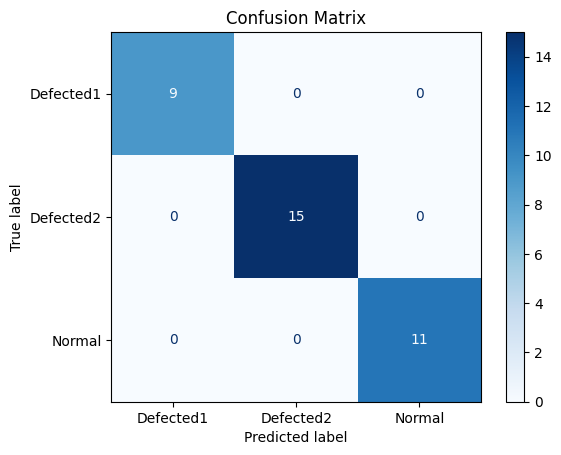

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_ds, class_names):
    true_labels = []
    predicted_labels = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        pred_labels = np.argmax(predictions, axis=-1)
        true_labels.extend(labels)
        predicted_labels.extend(pred_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

plot_confusion_matrix(model, test_ds, class_names)

**Finally Saving the model**

In [30]:
model.save("piston_defect_moddel.h5")

In [29]:
model_version=2
model.save(f"Saved_Model {model_version}")

INFO:tensorflow:Assets written to: Saved_Model 2\assets


INFO:tensorflow:Assets written to: Saved_Model 2\assets
